# Election Financial Data Analysis

This notebook integrates data loading, exploratory analysis, modeling, and results into one cohesive document. All warnings are suppressed, and data slices are explicitly copied to avoid `SettingWithCopyWarning`.

## 1. Setup and Imports

We’ll load libraries, configure plotting styles, and suppress warnings.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

Matplotlib is building the font cache; this may take a moment.


## 2. Data Loading and Cleaning

Load the election financial dataset, assign column names, standardize text, and prepare the data for analysis.

In [4]:
#read in data
data = pd.read_csv('weball06.csv', header = None)

#create column names
column_names = ['CAND_ID', 'CAND_NAME', 'CAND_ICI', 'PTY_CD', 'CAND_PTY_AFFILIATION', 'TTL_RECEIPTS', 'TRANS_FROM_AUTH',
                                              'TTL_DISB', 'TRANS_TO_AUTH', 'COH_BOP', 'COH_COP', 'CAND_CONTRIB', 'CAND_LOANS', 'OTHER_LOANS', 'CAND_LOAN_REPAY',
                                              'OTHER_LOAN_REPAY', 'DEBTS_OWED_BY', 'TTL_INDIV_CONTRIB', 'CAND_OFFICE_ST', 'CAND_OFFICE_DISTRICT', 'SPEC_ELECTION',
                                              'PRIM_ELECTION', 'RUN_ELECTION', 'GEN_ELECTION', 'GEN_ELECTION_PERCENT', 'OTHER_POL_CMTE_CONTRIB', 'POL_PTY_CONTRIB',
                                              'CVG_END_DT', 'INDIV_REFUNDS', 'CMTE_REFUNDS']
data.columns = column_names

#convert any lowercase to uppercase
data['CAND_PTY_AFFILIATION'] = data['CAND_PTY_AFFILIATION'].str.upper()
data['SPEC_ELECTION'] = data['SPEC_ELECTION'].str.upper()
data['PRIM_ELECTION'] = data['PRIM_ELECTION'].str.upper()
data['RUN_ELECTION'] = data['RUN_ELECTION'].str.upper()
data['GEN_ELECTION'] = data['GEN_ELECTION'].str.upper()


data.head()


,CAND_ID,CAND_NAME,CAND_ICI,PTY_CD,CAND_PTY_AFFILIATION,TTL_RECEIPTS,TRANS_FROM_AUTH,TTL_DISB,TRANS_TO_AUTH,COH_BOP,...,SPEC_ELECTION,PRIM_ELECTION,RUN_ELECTION,GEN_ELECTION,GEN_ELECTION_PERCENT,OTHER_POL_CMTE_CONTRIB,POL_PTY_CONTRIB,CVG_END_DT,INDIV_REFUNDS,CMTE_REFUNDS
0,H6AK00136,"VONDERSAAR, FRANK J",C,1,DEM,1092.00,0.0,1091.00,0.0,0.00,...,NaN,L,NaN,NaN,NaN,0.00,0.0,08/23/2006,0.0,0.0
1,H6AK00144,"BENSON, DIANE E",C,1,DEM,198951.60,0.0,192486.89,0.0,0.00,...,NaN,W,NaN,L,67.0,0.00,10000.0,12/31/2006,1000.0,0.0
2,H6AK00045,"YOUNG, DONALD E",I,2,REP,1919786.62,0.0,1959811.40,231000.0,1898567.49,...,NaN,W,NaN,W,94.0,707822.26,98.0,12/31/2006,4200.0,2300.0
3,H2AL01119,"BELK, JUDY MCCAIN",C,1,DEM,200.00,0.0,534.28,0.0,438.60,...,NaN,NaN,NaN,NaN,NaN,0.00,0.0,12/31/2006,0.0,0.0
4,H6AL01052,"BECKERLE, VIVIAN SHEFFIELD",C,1,DEM,16746.00,0.0,13482.00,0.0,0.00,...,NaN,W,NaN,L,31.0,2500.00,2300.0,10/18/2006,0.0,0.0


## 3. Exploratory Data Analysis (EDA)

### 3.1 Total Receipts by Party Affiliation

Visualize overall money raised by each party.

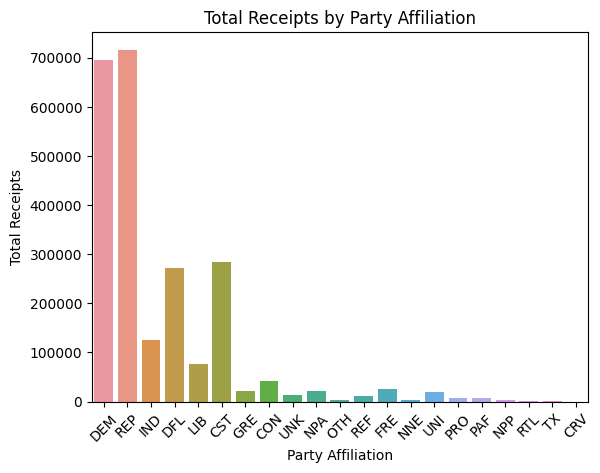

In [5]:
#Show difference between party affiliation and total receipts
barplot = sns.barplot(x = 'CAND_PTY_AFFILIATION', y = 'TTL_RECEIPTS', data = data, errorbar = None, order = data.groupby('CAND_PTY_AFFILIATION').TTL_RECEIPTS.sum().sort_values(ascending = False).index)
barplot.set(xlabel = 'Party Affiliation', ylabel = 'Total Receipts', title = 'Total Receipts by Party Affiliation')
barplot.set_xticklabels(barplot.get_xticklabels(), rotation = 45)
plt.show()


Republicans and Democrats clearly have the highest amount of money donated. Followed by the Constitution party and the Democratic-Farmer-Labor party.

### 3.2 Top Six Parties Breakdown

Filter to the six parties with the highest receipts and re-plot.

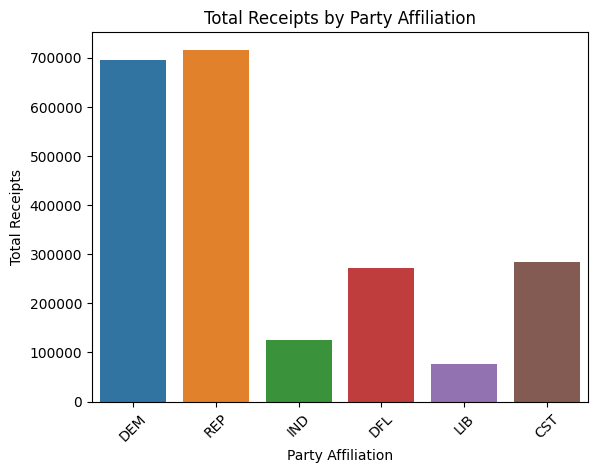

In [7]:
#Create database with political parties DEM, REP, IND, DFL, LIB, CST
split_data = data[data['CAND_PTY_AFFILIATION'].isin(['DEM', 'REP', 'IND', 'DFL', 'LIB', 'CST'])]

#New bar plot
plot = sns.barplot(x = 'CAND_PTY_AFFILIATION', y = 'TTL_RECEIPTS', data = split_data, errorbar = None, order = split_data.groupby('CAND_PTY_AFFILIATION').TTL_RECEIPTS.sum().sort_values(ascending = False).index)
plot.set(xlabel = 'Party Affiliation', ylabel = 'Total Receipts', title = 'Total Receipts by Party Affiliation')
plot.set_xticklabels(plot.get_xticklabels(), rotation = 45)
plt.show()


### 3.3 Funding Sources by Party

Stacked bar chart of funding sources for each major party.

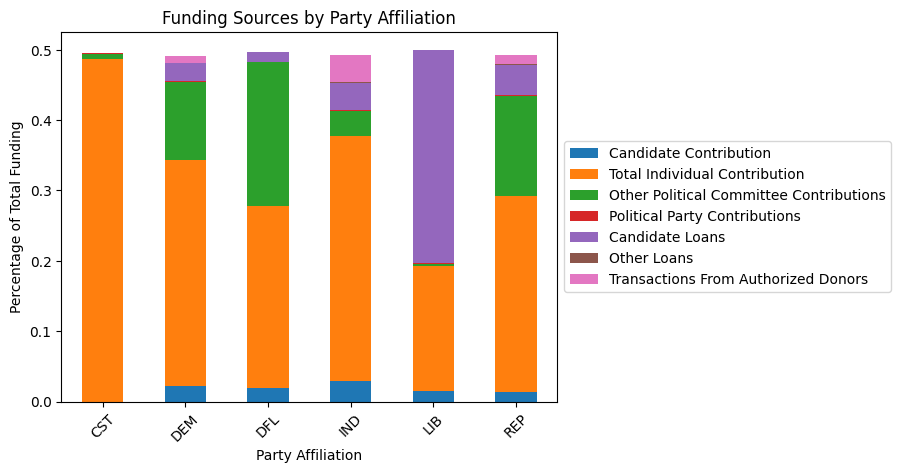

In [8]:
#Let's look at where the money is coming from for each party
party_funding = split_data.groupby('CAND_PTY_AFFILIATION')[['TTL_RECEIPTS', 'CAND_CONTRIB', 'TTL_INDIV_CONTRIB', 'OTHER_POL_CMTE_CONTRIB', 'POL_PTY_CONTRIB', 'CAND_LOANS', 'OTHER_LOANS', 'TRANS_FROM_AUTH']].sum()

#Normalized
party_funding_norm = party_funding.div(party_funding.sum(axis=1), axis=0)
part_funding_norm = party_funding_norm.reindex(['DEM', 'REP', 'IND', 'DFL', 'LIB', 'CST'])
party_funding_norm

#Plot without total receipts
plot = party_funding_norm.drop('TTL_RECEIPTS', axis = 1).plot(kind = 'bar', stacked = True, title = 'Funding Sources by Party Affiliation')
plot.set(xlabel = 'Party Affiliation', ylabel = 'Percentage of Total Funding')
plot.set_xticklabels(plot.get_xticklabels(), rotation = 45)
plt.legend(loc='center left', labels = ['Candidate Contribution', 'Total Individual Contribution', 'Other Political Committee Contributions',
                                        'Political Party Contributions', 'Candidate Loans', 'Other Loans', 'Transactions From Authorized Donors'],bbox_to_anchor=(1.0, 0.5))
plt.show()



Shows where the money is coming from for the parties. Most campaigns seem to be heavily reliant on contributions from the individual. With the exception of the libertarian party, where candidates seem to get a lot of money from loans. 

### 3.4 Overall Funding Source Distribution

Pie chart showing the breakdown of all funding sources across parties.

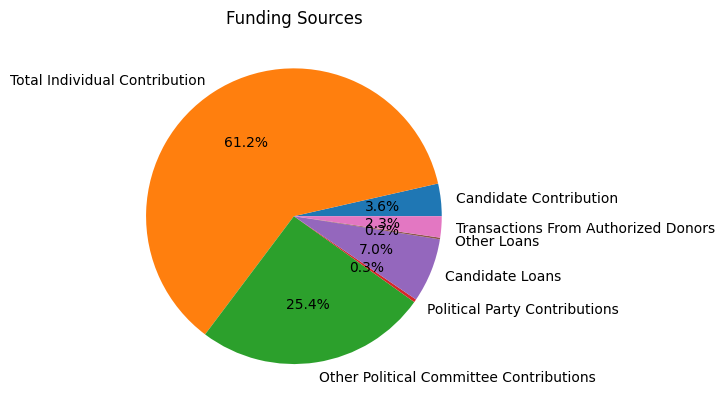

In [9]:
funding_sources = split_data[['TTL_RECEIPTS', 'CAND_CONTRIB', 'TTL_INDIV_CONTRIB', 'OTHER_POL_CMTE_CONTRIB', 'POL_PTY_CONTRIB', 'CAND_LOANS', 'OTHER_LOANS', 'TRANS_FROM_AUTH']].sum()

#pie chart without total receipts
funding_sources.drop(['TTL_RECEIPTS']).plot(kind = 'pie', autopct = '%1.1f%%', title = 'Funding Sources', labels = ['Candidate Contribution', 'Total Individual Contribution', 'Other Political Committee Contributions',
                                                                                                                    'Political Party Contributions', 'Candidate Loans', 'Other Loans', 'Transactions From Authorized Donors'], legend = False)
plt.show()

This is the breakdown across all the parties just to be able to compare. Most of the parties we looked at follow this at least a little. Individual contribution drives most campaigns. As a society the people do have power when it comes to candidates and it's more than we might think. I know a lot of people look at candidates receiving millions from super PACs but the individual is still the most important financial asset to a candidates campaign. 

## 4. Modeling: Impact of Total Receipts on General Election Outcome

Prepare data for logistic regression and evaluate performance.

In [10]:
#data set just of people who either won or lost
general = data[data['GEN_ELECTION'].isin(['W', 'L'])]

#Analyze if total receipts is a good predictor of winning General election
#Create new column with 1 for win and 0 for loss
general.loc[:, 'Win'] = np.where(general['GEN_ELECTION'] == 'W', 1, 0)

Y = general['Win']
X = general['TTL_RECEIPTS']

#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

#Standardize data
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train.values.reshape(-1,1))
X_test = scaler.transform(X_test.values.reshape(-1,1))

#Fit model
model = LogisticRegression()
model.fit(X_train, y_train)

#Predict
y_pred = model.predict(X_test)

#Performance metrics
print(classification_report(y_test, y_pred, zero_division=1))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.55      0.83      0.66        88
           1       0.72      0.39      0.51        99

    accuracy                           0.60       187
   macro avg       0.64      0.61      0.59       187
weighted avg       0.64      0.60      0.58       187

[[73 15]
 [60 39]]


I wanted to explore whether or not the total receipts had an effect on whether or not a candidate won the primary election. I ran a logistic model to see if total funds did indeed have an impact on winning. Class 0 has a higher recall when compared to Class 1 which that total receipts is a better predictor of a candidate losing when they have less total receipts. This could indicate that the less receipts a candidate has the more likely they are to lose. The lower recall for Class 1 could indicate that total receipts isn't a guarantee that a candidate will win. However there is a high precision rate when predicting wins which means when the model predicts a win, that prediction is more reliable which could indicate that above a certain threshold of total receipts the probability of winning increases. The model accuracy is 60% which is semi-strong but there are likely other factors that contribute to candidate success as well. 

It's important to note that this is not measuring causation of the two variables. A candidate with lower funding could also just be an unpopular candidate who gets less funding and loses because of that, and on the other hand, a candidate with high funding could just be more popular, and gets more funding and wins because of that. There are also numerous other factors that goes into a candidates level of funding and whether or not a candidate wins that this model does not capture. 

## 5. AUC-ROC Analysis

Calculate and plot the ROC curve to assess model discrimination.

AUC: 0.815


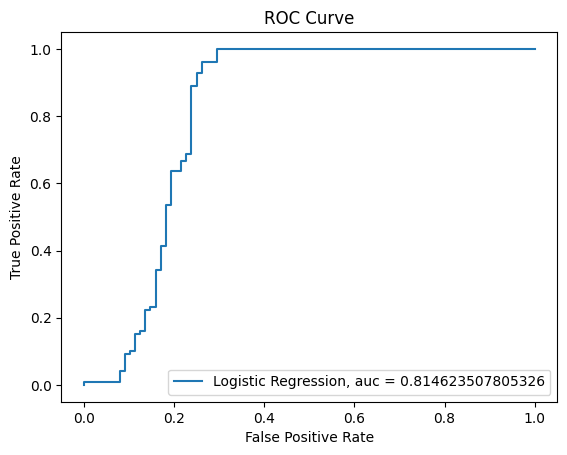

In [11]:
#AUC-ROC Score
y_pred_prob = model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred_prob)
print('AUC: %.3f' % auc)

#ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label = 'Logistic Regression, auc = ' + str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc = 4)
plt.show()

This ROC Curve and the AUC score indicate that this model is a pretty good predictor of differentiator between winning and losing. This just means that using a logistic model in this case makes sense. 

## 6. Conclusions

- **Model Accuracy**: ~60%
- **Key Insight**: Higher funding correlates with increased probability of winning but is not the sole determinant.
- **Next Steps**:
  1. Incorporate additional features (e.g., incumbency, region).
  2. Tune hyperparameters or explore nonlinear models.
  3. Analyze temporal changes beyond 2006 data.
  4. Use updated election data for more modern results. 

*End of analysis.*